# PyTorch: Training CIFAR-10 using the AIStore Pytorch Plugin

We train a classifier using the CIFAR-10 Dataset ([Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009). Note that this notebook was run on `Python 3.11.9`.

In [ ]:
! pip install -r ../../aistore/common_requirements --quiet
! pip install -r ../../aistore/pytorch/dev_requirements --quiet
! pip install pillow torchvision

#### 1). Import necessary packages, define constants, and create AIS Client.

In [1]:
try:
    from aistore.sdk import Client
    from aistore.pytorch import AISBaseIterDataset
    from aistore.sdk.ais_source import AISSource
except:

    # Use local version of aistore if pip version is too old
    import sys
    sys.path.append("../../")

    from aistore.sdk import Client
    from aistore.pytorch import AISBaseIterDataset
    from aistore.sdk.ais_source import AISSource
import requests
import tarfile
from io import BytesIO
import pickle
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
from PIL import Image

from itertools import islice
from typing import List, Union, Dict
from torch.utils.data import get_worker_info

In [2]:
AIS_ENDPOINT = "http://localhost:8080"
AIS_PROVIDER = "ais"
BCK_NAME = "data-bck"

DATASET_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

client = Client(endpoint=AIS_ENDPOINT)

#### 2). Load the CIFAR-10 dataset into a bucket in our AIS Cluster.

In [3]:
bucket = client.bucket(BCK_NAME, AIS_PROVIDER)
try:
    bucket.create(exist_ok=False)

    print("Downloading dataset...")
    filename = "cifar-10-python.tar.gz"

    headers = {
        "User-Agent": "Mozilla/5.0" 
    }
    response = requests.get(DATASET_URL, headers=headers, stream=True)
    response.raise_for_status()

    data = BytesIO(response.content)

    members = []
    with tarfile.open(fileobj=data, mode="r:gz") as file:
        members = file.getmembers()

        print("Putting files into buckets...")

        for member in members:
            if member.isfile():
                extracted_file = file.extractfile(member)
                bucket.object(member.name).put_content(extracted_file.read())
        
    print("Done putting files into buckets.")

    print("Cleaned up downloaded dataset.")
except Exception as e:
    print("Bucket already has dataset! Nothing will be done.")
    bucket.create(exist_ok=True)

Putting files into buckets...
Done putting files into buckets.
Cleaned up downloaded dataset.


#### 3). Extend AISBaseIterDataset to easily create an Iterable-style dataset that can parse CIFAR-10 pickle files.

In [14]:
class CIFAR10Dataset(AISBaseIterDataset):
    def __init__(
        self,
        cifar_ais_source: AISSource,
        transform: transforms.Compose,
        prefix_map: Dict[AISSource, Union[str, List[str]]] = {}
    ):
        super().__init__(cifar_ais_source, prefix_map)
        self._transform = transform
        self._reset_iterator()

    def __iter__(self):
        worker_info = get_worker_info()            
            
        if worker_info is None or worker_info.num_workers == 1:
            # If not using multiple workers, load directly
            current_iterator = self._iterator
        else:
            current_iterator = islice(self._iterator, worker_info.id, None, worker_info.num_workers)

        # Slice iterator based on worker id as starting index (0, 1, 2, ..) and steps of total workers
        for obj in current_iterator:
            obj_file = BytesIO(obj.get().read_all())

            cifar_dict = pickle.load(obj_file, encoding='bytes')

            data = cifar_dict[b"data"]
            labels = cifar_dict[b"labels"]

            # Ensure the data is in the correct shape
            assert data.shape == (10000, 3072), "CIFAR data files each have shape (10000, 3072)"
            assert len(labels) == 10000, "CIFAR files each store 10000 labels"
            
            # Reshape the data to (10000, 3, 32, 32)
            reshaped_data = data.reshape(10000, 3, 32, 32)
            
            # Transpose the data to (10000, 32, 32, 3) to match the image format (height, width, channels)
            reshaped_data = reshaped_data.transpose(0, 2, 3, 1)
            
            # Get list of images tensors
            image_tensors = [self._transform(Image.fromarray(image.astype('uint8'), 'RGB')) for image in reshaped_data]

            yield from iter(zip(image_tensors, labels))

#### 4). Define our transformation (Image -> Tensor and normalzing mean/stdev).

In [15]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)), # reduce this size if your training exits due to OOM or decrease batch size
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

#### 5). Create our training and validation datasets. 

Note that we use the same bucket for both, but by using the `prefix_map` arg, we can control which AIS objects are used in each dataset

In [16]:
"""
Prefix map allows us to choose specific objects from the bucket to be included in the dataset.
The map is a dictionary mapping the AISSource (bucket) to a list of prefixes (in this case object names).
If prefix map is None or not specified, then all objects will be included.
"""

train_dataset = CIFAR10Dataset(
    cifar_ais_source=bucket,
    prefix_map={
        bucket: [
            "cifar-10-batches-py/data_batch_1",
            "cifar-10-batches-py/data_batch_2",
            "cifar-10-batches-py/data_batch_3",
            "cifar-10-batches-py/data_batch_4",
            "cifar-10-batches-py/data_batch_5",
        ]
    },
    transform=transform
)

test_dataset = CIFAR10Dataset(
    cifar_ais_source=bucket,
    prefix_map={
        bucket: "cifar-10-batches-py/test_batch"
    },
    transform=transform
)

### 6). Create our training and validation dataloaders and configure workers and batch size. 

In [17]:
BATCH_SIZE = 5
NUM_WORKERS = 3

training_loader = DataLoader(
    dataset=train_dataset,
    num_workers=NUM_WORKERS,
    batch_size = BATCH_SIZE,
)

validation_loader = DataLoader(
    dataset=test_dataset,
    num_workers=NUM_WORKERS,
    batch_size = BATCH_SIZE,
)

### 7). Define a multi-layer Convolutional Neural Network (CNN) to use as our model.

In [18]:
class CIFARClassifier(torch.nn.Module):
    def __init__(self):
        super(CIFARClassifier, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = torch.nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(256)
        
        # Pooling layer
        self.pool = torch.nn.MaxPool2d(2, 2)
        
        # Adaptive pooling layer to handle variable input sizes
        self.adaptive_pool = torch.nn.AdaptiveAvgPool2d((2, 2))
        
        # Fully connected layers
        self.fc1 = torch.nn.Linear(256 * 2 * 2, 512)
        self.fc2 = torch.nn.Linear(512, 10)
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(torch.functional.F.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.functional.F.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.functional.F.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.functional.F.relu(self.bn4(self.conv4(x))))
        
        # Apply adaptive pooling to ensure the output size is (2, 2)
        x = self.adaptive_pool(x)
        
        # Flatten the image
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(x)
        x = torch.functional.F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 8). Define additional hyperparameters, create our classifier, loss function, and optimizer, and define class names.

In [19]:
LEARNING_RATE = 0.0001 #0.001
MOMENTUM = 0.9
EPOCH_NUM = 19
WEIGHT_DECAY = 0.000125

classifier = CIFARClassifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    classifier.parameters(), 
    lr=LEARNING_RATE, 
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
)

classes = (
    "airplane",									
    "automobile",									
    "bird",								
    "cat",									
    "deer",									
    "dog",									
    "frog",										
    "horse",										
    "ship",									
    "truck"
)

### 9). Train the model by passing the data through our model and performing back prop to calculate gradients. 

Then, validate the trained model at each epoch.

In [20]:
for epoch in range(EPOCH_NUM):  # loop over the dataset multiple times

    print(f"EPOCH {epoch + 1}\n-----------")

    loss = 0
    i = 0
    for i, (images, labels) in enumerate(training_loader):
                            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss += loss.item()

    print(f"Samples Processed: {(i+1) * BATCH_SIZE}, Loss: {loss / 100}")

    # Validation
    classifier.eval()
    predictions = {name: [0, 0] for name in classes}
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:

            if len(labels) != BATCH_SIZE:
                print(len(labels))
            outputs = classifier(images)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += len(labels)

            if epoch == EPOCH_NUM - 1:
                for label, prediction in zip(labels, predicted):
                    if label == prediction:
                        predictions[classes[label]][0] += 1
                    predictions[classes[label]][1] += 1

        if epoch == EPOCH_NUM - 1:
            for name, data in predictions.items():
                successes, guesses = data[0], data[1]
                print(f"Accuracy for class {name}: {100 * successes / guesses}%")

        print(f"Accuracy: {100 * correct / total}%\n")

print("-----------\nFinished Training")



EPOCH 1
-----------


Samples Processed: 50000, Loss: 0.04675844684243202
Accuracy: 44.52%

EPOCH 2
-----------
Samples Processed: 50000, Loss: 0.04545032978057861
Accuracy: 57.24%

EPOCH 3
-----------
Samples Processed: 50000, Loss: 0.04300606623291969
Accuracy: 65.3%

EPOCH 4
-----------
Samples Processed: 50000, Loss: 0.0419011227786541
Accuracy: 69.52%

EPOCH 5
-----------
Samples Processed: 50000, Loss: 0.039300207048654556
Accuracy: 72.0%

EPOCH 6
-----------
Samples Processed: 50000, Loss: 0.03518728166818619
Accuracy: 73.37%

EPOCH 7
-----------
Samples Processed: 50000, Loss: 0.03255374729633331
Accuracy: 74.45%

EPOCH 8
-----------
Samples Processed: 50000, Loss: 0.03144019469618797
Accuracy: 75.51%

EPOCH 9
-----------
Samples Processed: 50000, Loss: 0.025155983865261078
Accuracy: 75.28%

EPOCH 10
-----------
Samples Processed: 50000, Loss: 0.020765958353877068
Accuracy: 74.65%

EPOCH 11
-----------
Samples Processed: 50000, Loss: 0.019731147214770317
Accuracy: 74.52%

EPOCH 12
-----------
Sample

### EXTRA). Visualize each class using our dataset and matplotlib.

cat ship airplane frog automobile truck dog horse deer bird 

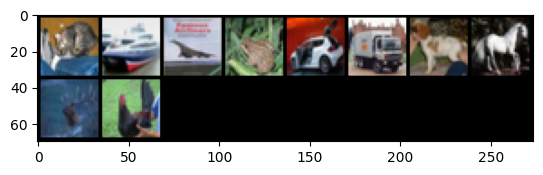

In [21]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Same as test dataset without normalization
vis_dataset = CIFAR10Dataset(
    cifar_ais_source=bucket,
    prefix_map={
        bucket: "cifar-10-batches-py/test_batch"
    },
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

matched_images = {}

for image, label in vis_dataset: 
    if label not in matched_images:
        matched_images[label] = image
    if len(matched_images.keys()) == len(classes):
        break

# Create a grid from the images and show them
img_grid = make_grid([image for image in matched_images.values()])
plt.imshow(img_grid.permute(1, 2, 0))
for label in matched_images.keys():
    print(classes[label], end=" ")